/home/jay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


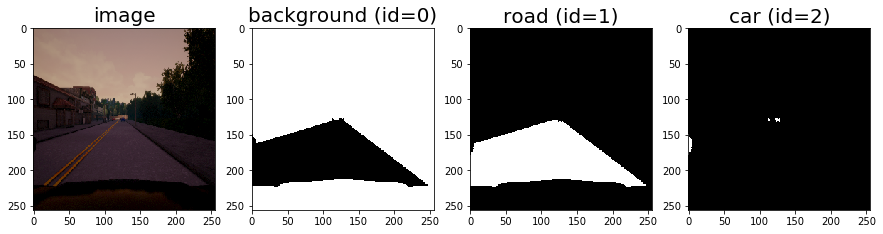

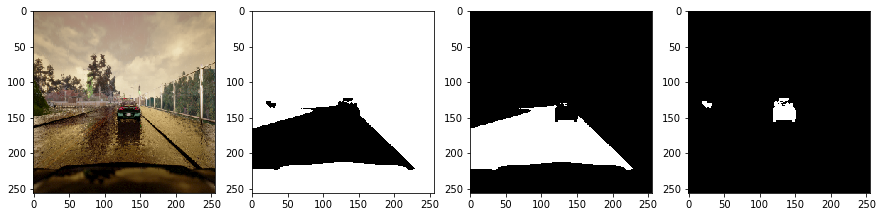

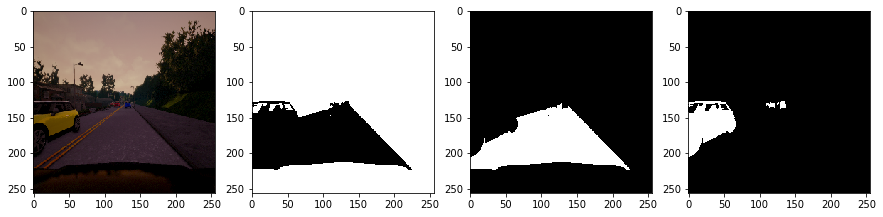

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from glob import glob
from helper5 import remove_hood, remap_seg, seg2labels

TRAINING_DIR = '../lyft_training_data/Train/'
RGB_DIR = 'CameraRGB'
SEG_DIR = 'CameraSeg'

# 0: nothing, 1: road + roadlines, 2: vehicles
SEG_MAP = {
    6: 1, 7: 1,
    10: 2
}
AOI_PERC = 0.83

# height, width
IMG_SIZE = (256, 256)

rgb_paths = glob(os.path.join(TRAINING_DIR, RGB_DIR, '*.png'))
seg_paths = glob(os.path.join(TRAINING_DIR, SEG_DIR, '*.png'))
random_ids = np.random.permutation(len(rgb_paths))

def preprocess_seg(seg):
    seg = remove_hood(seg,
                      perc_retain=AOI_PERC)
    seg = cv2.resize(seg,
                     (IMG_SIZE[1], IMG_SIZE[0]),
                     interpolation=cv2.INTER_NEAREST)
    seg = remap_seg(seg, SEG_MAP)
    return seg
    
for i in range(3):
    
    rgb_file = rgb_paths[random_ids[i]]
    seg_file = seg_paths[random_ids[i]]
    
    rgb = cv2.imread(rgb_file, cv2.IMREAD_COLOR)

    rgb = cv2.cvtColor(cv2.imread(rgb_file), cv2.COLOR_BGR2RGB)

    rgb = cv2.resize(rgb,
                     (IMG_SIZE[1], IMG_SIZE[0]))

    seg = preprocess_seg(cv2.imread(seg_file, cv2.IMREAD_COLOR)[:, :, 2])

    labels = seg2labels(seg)
    seg = seg * 100

    plt.figure(figsize=(15,15))
    plt.subplot(241), plt.imshow(rgb)
    if i == 0:
        plt.title('image', fontsize=20)
    plt.subplot(242), plt.imshow(labels[:, :, 0], cmap='gray')
    if i == 0:
        plt.title('background (id=0)', fontsize=20)
    plt.subplot(243), plt.imshow(labels[:, :, 1], cmap='gray')
    if i == 0:
        plt.title('road (id=1)', fontsize=20)
    plt.subplot(244), plt.imshow(labels[:, :, 2], cmap='gray')
    if i == 0:
        plt.title('car (id=2)', fontsize=20)
    plt.show()

Show by layers

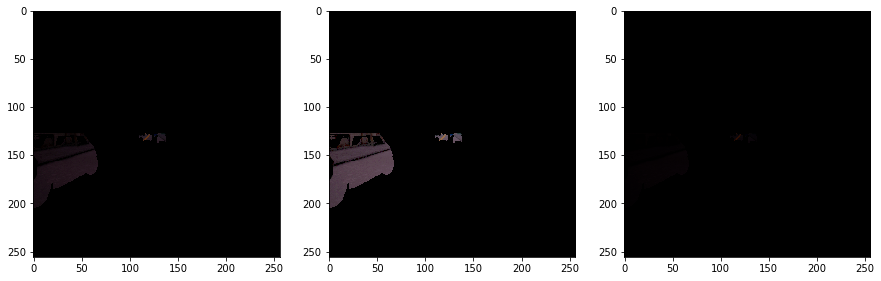

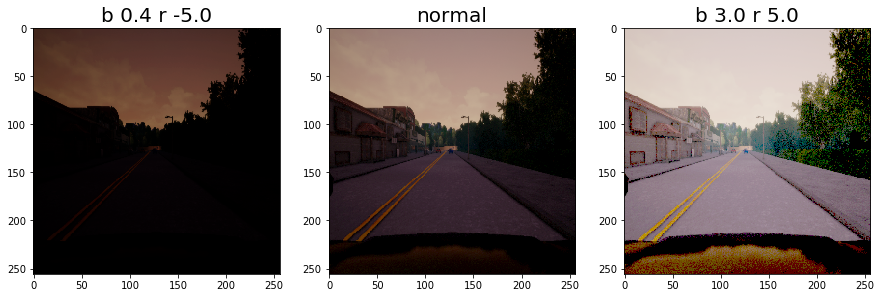

In [3]:
import random
min_brightness = 0.4
max_brightness = 3.0
min_rotate = -5.0
max_rotate = 5.0

rgb = cv2.imread(rgb_paths[random_ids[0]], cv2.IMREAD_COLOR)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

rgb = cv2.resize(rgb,
                 (IMG_SIZE[1], IMG_SIZE[0]))

seg = preprocess_seg(cv2.imread(seg_file, cv2.IMREAD_COLOR)[:, :, 2])



def rotate(input_image, input_seg, class_to_rotate, angle):
    angle = 0
    mask = np.stack(((input_seg == class_to_rotate),)*3, -1)
    only_cars = input_image * mask
    
#     M = cv2.getRotationMatrix2D((only_cars.shape[1]//2, only_cars.shape[0]//2), angle, 1.0)
#     return cv2.warpAffine(only_cars, M, (only_cars.shape[1], only_cars.shape[0]), flags=cv2.INTER_NEAREST)
    return only_cars
    
class Args():
    def __init__(self):
        pass

def random_gamma():
    min_brightness = 0.4
    max_brightness = 3.0
    factor = random.uniform(-1, 1)
    if factor > 0:
        # brighten
        gamma = 1 + ((max_brightness-1) * factor)
    else:
        # darken
        gamma = min_brightness + ((1 - min_brightness) * -factor)
    return gamma

def adj_brightness(input_image, gamma):
    if gamma == 0:
        gamma = 0.01
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    return cv2.LUT(input_image, table)

def augment(input_image, input_seg, args):
    gamma = random_gamma()
    input_image = adj_brightness(input_image, gamma)
    angle = random.uniform(-1*args.rotation, args.rotation)
    input_image = rotate(input_image, input_seg, 2, angle)
    return input_image

def random_augment(input_image, input_seg, args):
    if args.brightness == True and random.randint(0,1):
        gamma = random_gamma()
        input_image = adj_brightness(input_image, gamma)
        
    if args.rotation:
        angle = random.uniform(-1*args.rotation, args.rotation)
    
    return input_image

args = Args()
args.brightness = True
args.rotation = -5.0

random_augment(rgb, seg, args)

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(augment(rgb, seg, args))

plt.subplot(132), plt.imshow(augment(rgb, seg, args))

plt.subplot(133), plt.imshow(augment(rgb, seg, args))

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(adj_brightness(rgb, min_brightness))
plt.title('b {} r {}'.format(min_brightness, min_rotate), fontsize=20)

plt.subplot(132), plt.imshow(rgb)
plt.title('normal', fontsize=20)

plt.subplot(133), plt.imshow(adj_brightness(rgb, max_brightness))
plt.title('b {} r {}'.format(max_brightness, max_rotate), fontsize=20)

plt.show()

In [3]:
os.path.join(TRAINING_DIR, RGB_DIR, SEG_DIR, '0.png')

'../lyft_training_data/Train/CameraRGB/CameraSeg/0.png'

In [4]:
np.unique(seg)

array([0, 1, 2], dtype=uint8)

In [5]:
rgb.shape

(256, 256, 3)

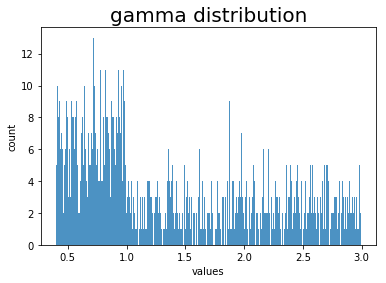

In [9]:
gammas = []
for i in range(1000):
    gammas.append(random_gamma())
plt.hist(gammas, bins=300,alpha=.8)
plt.title('gamma distribution'.format(max_brightness, max_rotate), fontsize=20)
plt.xlabel('values')
plt.ylabel('count')
plt.show()

In [2]:
# Saved big losses

%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from glob import glob
from helper5 import remove_hood, remap_seg, seg2labels

TRAINING_DIR = '../lyft_training_data/Train/'
RGB_DIR = 'CameraRGB'
SEG_DIR = 'CameraSeg'

# 0: nothing, 1: road + roadlines, 2: vehicles
SEG_MAP = {
    6: 1, 7: 1,
    10: 2
}
AOI_PERC = 0.83

# height, width
IMG_SIZE = (256, 256)

rgb_paths = glob(os.path.join(TRAINING_DIR, RGB_DIR, '*.png'))
seg_paths = glob(os.path.join(TRAINING_DIR, SEG_DIR, '*.png'))
random_ids = np.random.permutation(len(rgb_paths))

def preprocess_seg(seg):
    seg = remove_hood(seg,
                      perc_retain=AOI_PERC)
    seg = cv2.resize(seg,
                     (IMG_SIZE[1], IMG_SIZE[0]),
                     interpolation=cv2.INTER_NEAREST)
    seg = remap_seg(seg, SEG_MAP)
    return seg
    
for i in range(3):
    
    rgb_file = rgb_paths[random_ids[i]]
    seg_file = seg_paths[random_ids[i]]
    
    rgb = cv2.imread(rgb_file, cv2.IMREAD_COLOR)

    rgb = cv2.cvtColor(cv2.imread(rgb_file), cv2.COLOR_BGR2RGB)

    rgb = cv2.resize(rgb,
                     (IMG_SIZE[1], IMG_SIZE[0]))

    seg = preprocess_seg(cv2.imread(seg_file, cv2.IMREAD_COLOR)[:, :, 2])

    labels = seg2labels(seg)
    seg = seg * 100

    plt.figure(figsize=(15,15))
    plt.subplot(241), plt.imshow(rgb)
    if i == 0:
        plt.title('image', fontsize=20)
    plt.subplot(242), plt.imshow(labels[:, :, 0], cmap='gray')
    if i == 0:
        plt.title('background (id=0)', fontsize=20)
    plt.subplot(243), plt.imshow(labels[:, :, 1], cmap='gray')
    if i == 0:
        plt.title('road (id=1)', fontsize=20)
    plt.subplot(244), plt.imshow(labels[:, :, 2], cmap='gray')
    if i == 0:
        plt.title('car (id=2)', fontsize=20)
    plt.show()